In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm


In [ ]:
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 224
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 232.92it/s]


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [10]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [11]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 21, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7564 - loss: 0.6083
Epoch 1: val_accuracy improved from -inf to 0.65306, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 124s 700ms/step - accuracy: 0.7574 - loss: 0.6063 - val_accuracy: 0.6531 - val_loss: 1.4280 - learning_rate: 0.0010
Epoch 2/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9199 - loss: 0.2283
Epoch 2: val_accuracy improved from 0.65306 to 0.74830, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9200 - loss: 0.2278 - val_accuracy: 0.7483 - val_loss: 1.0071 - learning_rate: 0.0010
Epoch 3/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9645 - loss: 0.1216
Epoch 3: val_accuracy did not improve from 0.74830
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9644 - loss: 0.1219 - val_accuracy: 0.7381 - val_loss: 0.9001 - learning_rate: 0.0010
Epoch 4/21
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9658 - loss: 0.

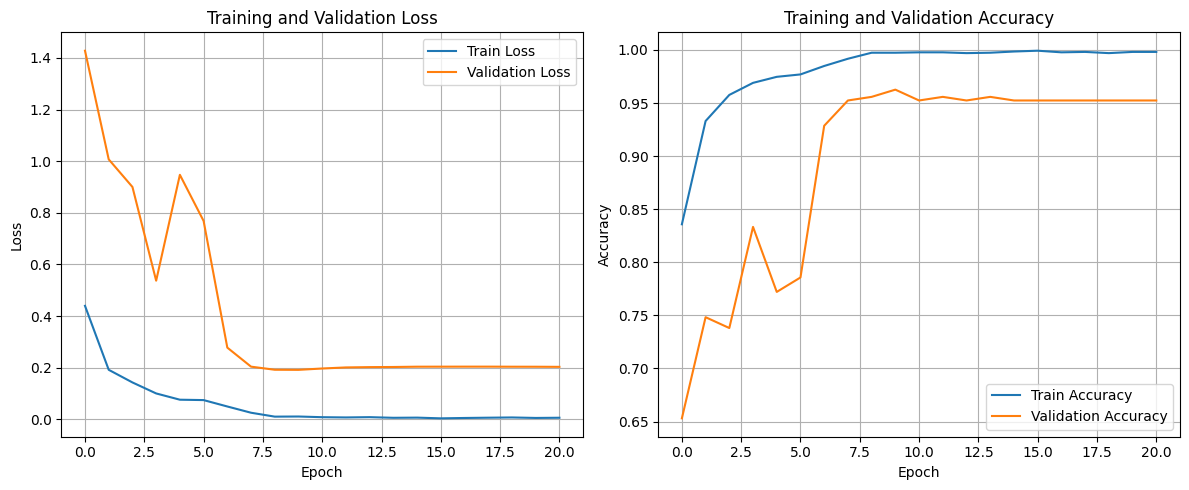

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 617ms/step


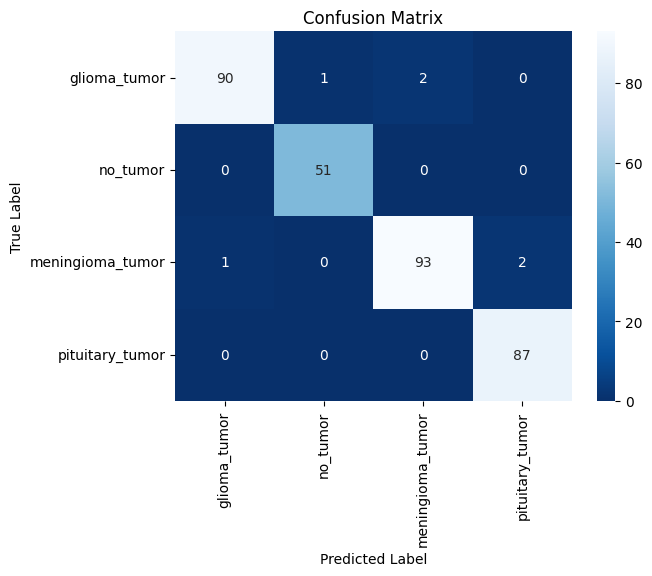

In [13]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        93
           1       0.98      1.00      0.99        51
           2       0.98      0.97      0.97        96
           3       0.98      1.00      0.99        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327

